In [3]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import cmocean
import urllib
import pandas as pd
from netCDF4 import Dataset



In [4]:
def getURL(myURL, outFile):
    response = urllib.urlretrieve(myURL, outFile)
    return(response)


In [5]:
def plot_map(grid, lats, lons, myPalette):
    southlat = lats.min()
    northlat = lats.max()
    westlon = lons.min()
    eastlon = lons.max()
    latdif = abs(northlat - southlat)
    londif = abs(westlon - eastlon)
    westedge = westlon - londif * 0.1
    eastedge = eastlon + londif * 0.1
    edgedif = abs(westedge-eastedge)
    northedge = northlat - latdif * 0.1
    southedge = southlat - latdif * 0.1
    mylons,  mylats = np.meshgrid(lons, lats)
    plt.figure(figsize=(12,8))
    map = Basemap(projection = 'merc', lat_0 = (southlat + northlat)/2, (lon_0) = (westlon + eastlon)/2,
        resolution = 'h', area_thresh = 0.1,
        llcrnrlon = westedge, llcrnrlat = southedge,
        urcrnrlon = eastedge, urcrnrlat = northedge)
    map.drawcoastlines()
    map.drawcountries()
    im1 = map.fillcontinents(color = '0.3')
    im2 = map.drawmapboundary()
    im3 = map.drawmeridians(np.arange((westedge - np.mod(westedge, 5)), (eastedge + np.mod(eastedge, 5)),5),
        labels=[True, False, False, True])
    im4 = map.drawparallels(np.arange((southedge - np.mod(southedge, 5)), (northedge + np.mod(northedge, 5)),5),
        labels=[True, False, False, True])
    im5 = map.pcolormesh(mylons, mylats, grid, shading = 'flat',cmap = myPalette, latlon = True)
    cb = map.colorbar(im5, "right", size = "5%", pad = "2%")
    plt.show()


## MUR SST

MUR (Multi-scale Ultra-high Resolution) is an analyzed SST product at 0.01-degree resolution going back to 2002, providing one of the longest satellite based time series at such high resolution (see https://podaac.jpl.nasa.gov/dataset/MUR-JPL-L4-GLOB-v4.1). The latest data available for a region off the west coast can be extracted and plotted by:


In [7]:
murURL = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41.nc?analysed_sst[(last):1:(last)][(22.):1:(51.)][(-140.):1:(-105)]'
result = getURL(murURL, 'murSST.nc')
sstFile = Dataset('murSST.nc')
sst = sstFile.variables['analysed_sst'][:,:,:]
latitude = sstFile.variables['latitude'][:]
longitude = sstFile.variables['longitude'][:]
sstFile.close()
sst = np.squeeze(sst)




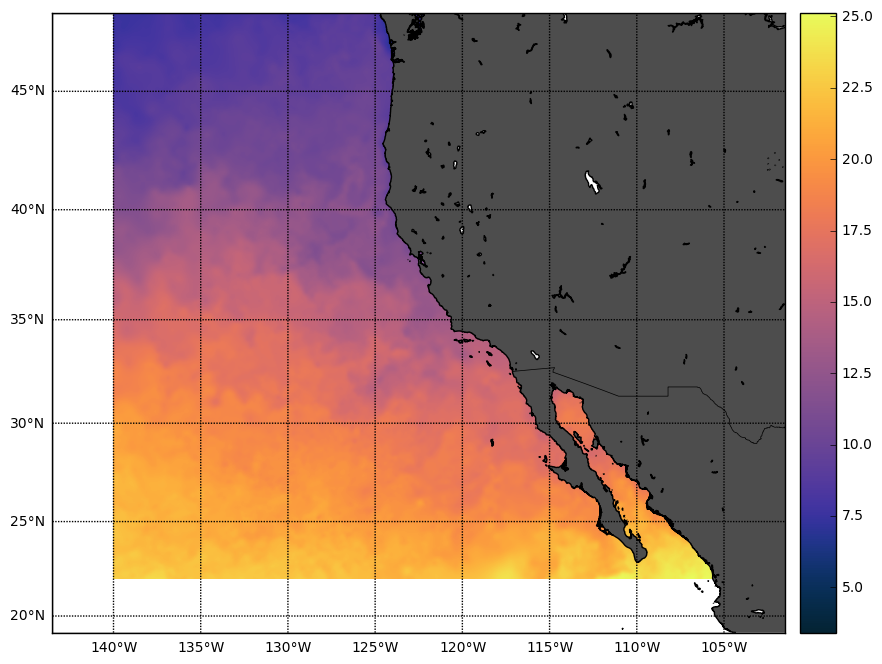

In [10]:
plot_map(sst, latitude, longitude, cmocean.cm.thermal)

## VIIRS SST and Chlorophyll

VIIRS (Visible Infrared Imaging Radiometer Suite)  is a scanning radiometer, that collects visible and infrared imagery and radiometric measurements of the land, atmosphere, cryosphere, and oceans. VIIRS data is used to measure cloud and aerosol properties, ocean color, sea and land surface temperature, ice motion and temperature, fires, and Earth's albedo.   Both NASA and NOAA provide VIIRS-based high resolution SST and chlorophyll products.

We look at the latest 3-day composite SST product at 750 meter resolution developed by ERD from a real-time NOAA product (see http://coastwatch.noaa.gov/cwn/cw_products_sst.html).  

In [14]:
viirsSSTUrl = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdVHsstaWS3day.nc?sst[(last):1:(last)][(0.0):1:(0.0)][(41.):1:(31.)][(-128.):1:(-115.)]'
result = getURL(viirsSSTUrl, 'viirsSST.nc')
viirssstFile = Dataset('viirsSST.nc')
viirsSST = viirssstFile.variables['sst'][:,:,:,:]
latitude = viirssstFile.variables['latitude'][:]
longitude = viirssstFile.variables['longitude'][:]
viirssstFile.close()
viirsSST = np.squeeze(viirsSST)



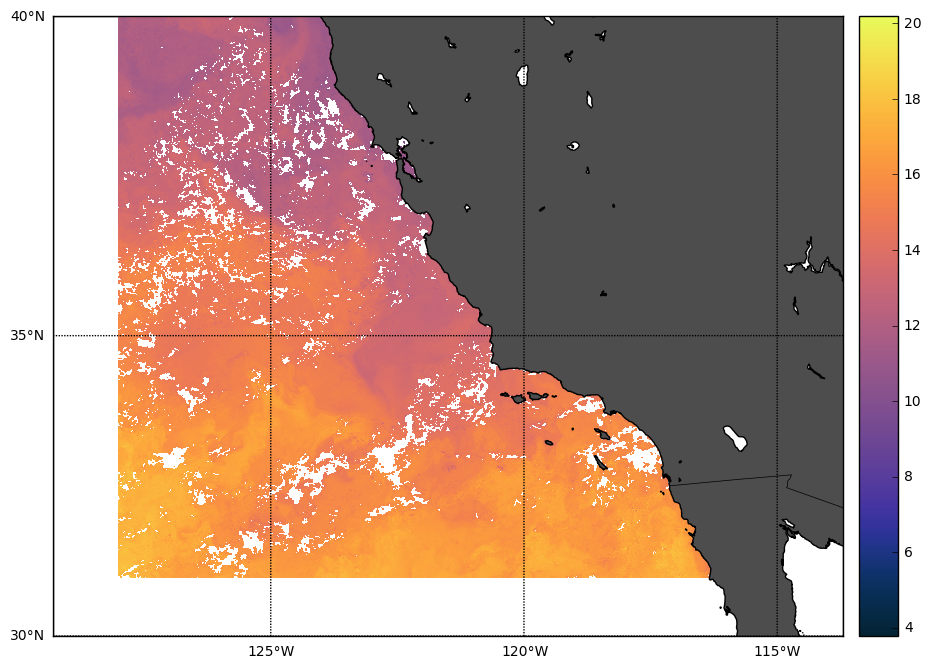

In [15]:
plot_map(viirsSST, latitude, longitude, cmocean.cm.thermal)

We can obtain a time series at a location,  here (36., -126.):


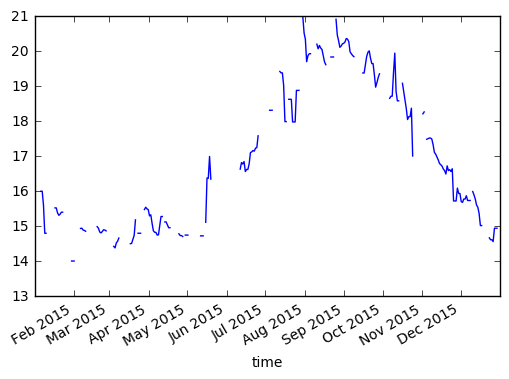

In [54]:
myURL = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdVHsstaWS3day.csv?sst[(2015-01-01):1:(2015-12-31)][(0.0):1:(0.0)][(36):1:(36)][(-126):1:(-126)]'
junk = pd.read_csv(myURL, parse_dates=True, index_col='time', skiprows=[1])
junk['sst'].plot()
plt.show()



We look at a similar 3-day composite for chloropyll for the same region from a scientific quality product developed by NOAA (see http://coastwatch.noaa.gov/cwn/cw_products_sst.html):


In [16]:
viirsChlaURL = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdVHNchla3day.nc?chla[(last):1:(last)][(0.0):1:(0.0)][(41.):1:(31.)][(-128.):1:(-115.)]'
result = getURL(viirsChlaURL, 'viirsSST.nc')
viirsChlaFile = Dataset('viirsSST.nc')
viirsChla = viirsChlaFile.variables['chla'][:,:,:,:]
latitude = viirsChlaFile.variables['latitude'][:]
longitude = viirsChlaFile.variables['longitude'][:]
viirsChlaFile.close()
viirsChla = np.squeeze(viirsChla)



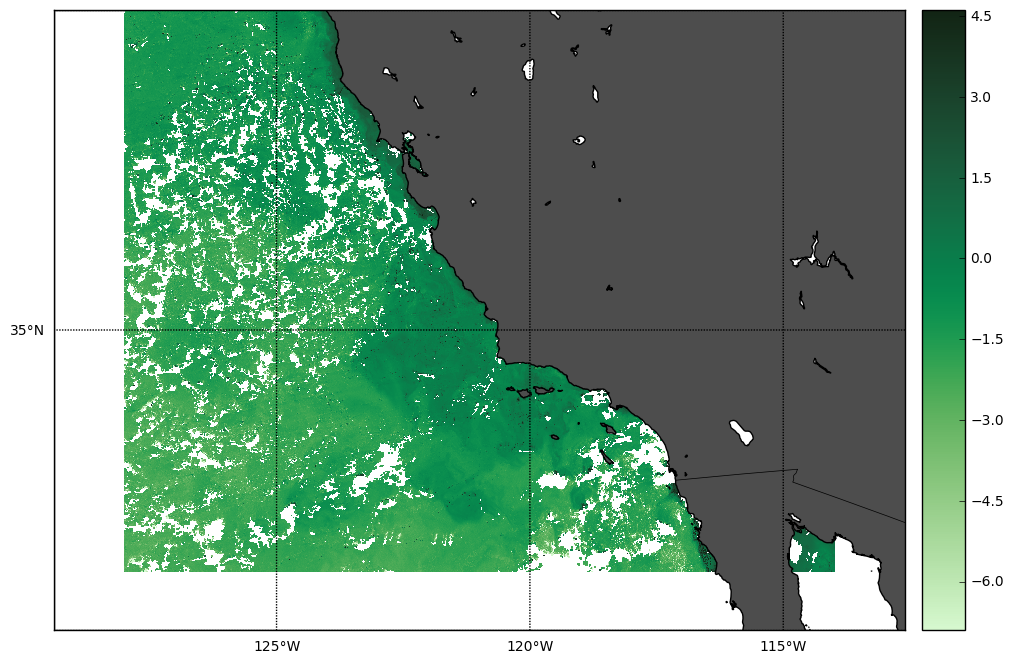

In [19]:
plot_map(np.log(viirsChla), latitude, longitude, cmocean.cm.algae)

## Temperature at 70m in the north Pacific from the SODA model output

This is an example of an extract from a 4-D dataset (results from the "Simple Ocean Data Assimilation (SODA)" model - - see http://www.atmos.umd.edu/~ocean/), and illustrate the case where the z-coordinate does not have the default name "altitude".  Water temperature at 70m depth is extracted for the North Pacific Ocean.


In [22]:
soda70URL = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/hawaii_d90f_20ee_c4cb.nc?temp[(2010-12-15):1:(2010-12-15)][(70.02):1:(70.02)][(20.25):1:(60.25)][(135.25):1:(240.25)]'
result = getURL(soda70URL, 'soda70.nc')
soda70File = Dataset('soda70.nc')
soda70Temp = soda70File.variables['temp'][:,:,:,:]
latitude = soda70File.variables['latitude'][:]
longitude = soda70File.variables['longitude'][:]
soda70File.close()
soda70Temp = np.squeeze(soda70Temp)



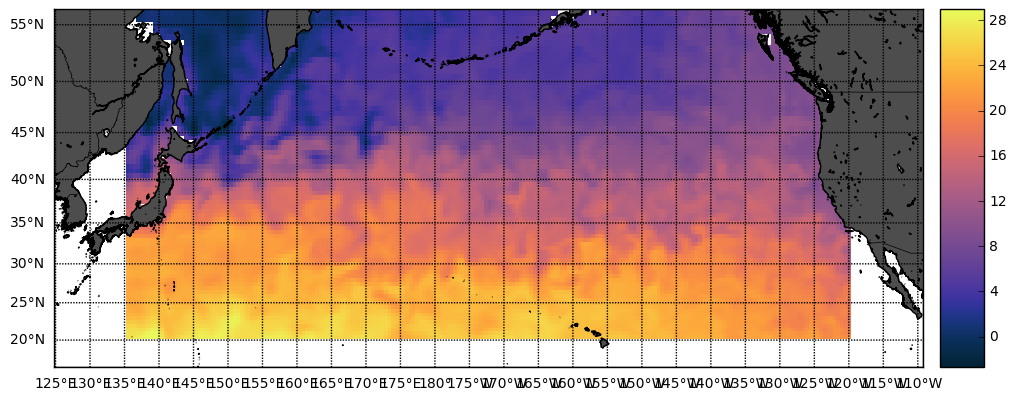

In [24]:
plot_map(soda70Temp, latitude, longitude, cmocean.cm.thermal)

## IFREMER

The French agency IFREMER also has an ERDDAP server. We obtain salinity data at 75 meters from "Global Ocean, Coriolis Observation Re-Analysis CORA4.1" model off the west coast of the United States.


In [25]:
ifrURL = 'http://www.ifremer.fr/erddap/griddap/ifremer_tds0_6080_109e_ed80.nc?PSAL[(2013-05-15):1:(2013-05-15)][(75.):1:(75.)][(30.):1:(50.)][(-140.0):1:(-110.)]'
result = getURL(ifrURL, 'ifr.nc')
ifrFile = Dataset('ifr.nc')
ifrPSAL = ifrFile.variables['PSAL'][:,:,:,:]
latitude = ifrFile.variables['latitude'][:]
longitude = ifrFile.variables['longitude'][:]
ifrFile.close()
ifrPSAL = np.squeeze(ifrPSAL)




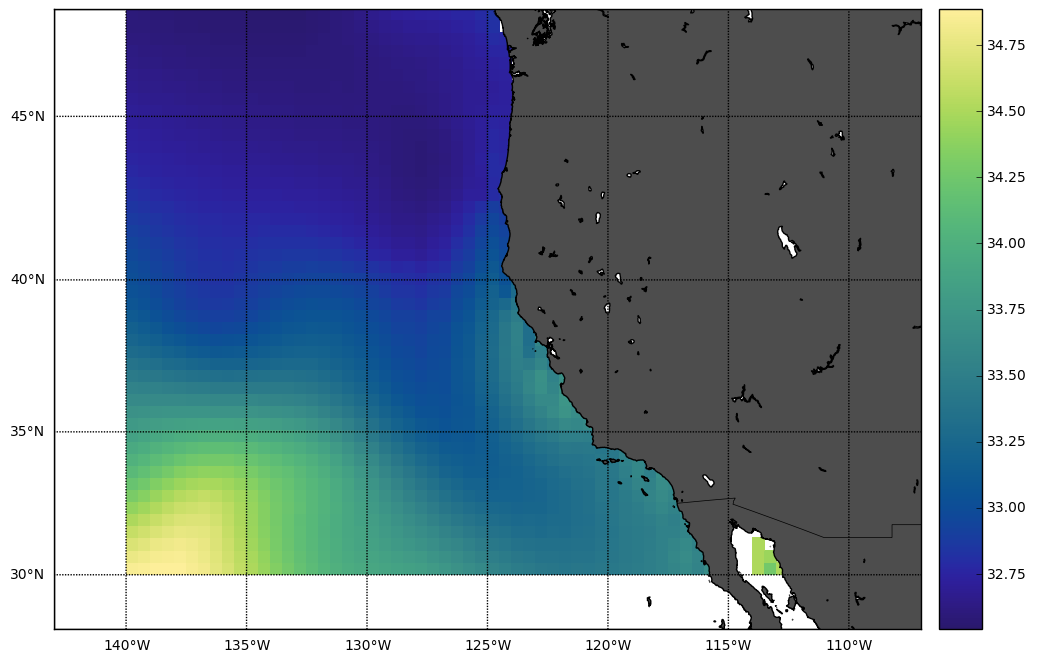

In [26]:
plot_map(ifrPSAL, latitude, longitude, cmocean.cm.haline)

## CalCOFI data


CalCOFI (California Cooperative Oceanic Fisheries Investigations - http://www.calcofi.org) is a multi-agency partnership formed in 1949 to investigate the collapse of the sardine population off California. The organization's members are from NOAA Fisheries Service, Scripps Institution of Oceanography, and California Department of Fish and Wildlife. The scope of this research has evolved into the study of marine ecosystems off California and the management of its fisheries resources.  The nearly complete CalCOFI data, both physical and biological, are available through ERDDAP.

The following retrieves the data that are used in a script developed by Dr. Andrew Leising of the Southwest Fisheries Science Center.  The original script has been used to automate the generation of several yearly reports about the California Current Ecosystem.   The script gets chlorophyll and primary productivity data from the hydrocasts,  and then calculates a seasonally adjusted chlorophyll anomaly as well as a seasonally adjusted primary productivity.  The full modified script can be seen in the R notebook.

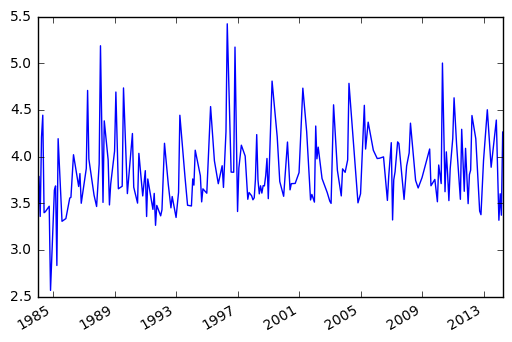

In [55]:
ccsURL = 'http://coastwatch.pfeg.noaa.gov/erddap/tabledap/siocalcofiHydroCasts.csv?year,month,intchl,intc14&time>=1984-01-01T00:00:00Z&time<=2014-04-17T05:35:00Z'
junk = pd.read_csv(ccsURL, parse_dates=True,  skiprows=[1])
junk1 = junk.groupby(['year', 'month']).mean()
myIndex = np.array(junk1.index.labels[0])
years = np.array(junk1.index.levels[0])
years = years[myIndex]
myIndex = np.array(junk1.index.labels[1])
months = np.array(junk1.index.levels[1])
months = months[myIndex]
df = pd.DataFrame({'year':years, 'month': months, 'day':1})
myTimes = pd.to_datetime(df)
intch1 = np.array(junk1['intchl'])
intch1 = pd.Series(np.log(intch1), index=myTimes)
intch1.plot()
plt.show()

### CPS Trawl Surveys


The CPS (Coastal Pelagic Species) Trawl Life History Length Frequency Data contains the length distribution of a subset of individuals from a species (mainly non-target) caught during SWFSC-FRD fishery independent trawl surveys of coastal pelagic species. Measured lengths for indicated length type (fork, standard, total, or mantle) were grouped in 10 mm bins (identified by the midpoint of the length class) and counts are recorded by sex.

We will look at the number and location of sardines (Sardinops sagax) in the tows in March 2010 and 2011, and compare with monthly SST from satellites.  


### NDBC Buoys

NOAA's National Data Buoy Center (NDBC) collects world-wide data from buoys in the ocean. <span style="color:red">ERDDAP</span> can be searched for the location of all buoys in a bounding box with latitudes(37N, 47N) and longitudes (124W, 121W) and the results plotted:


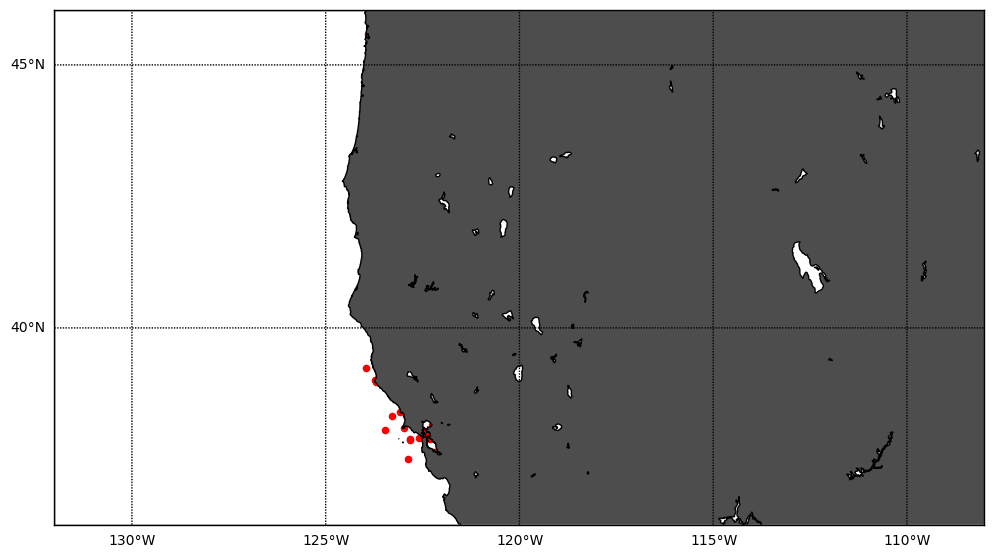

In [48]:
ndbcURL = 'http://coastwatch.pfeg.noaa.gov/erddap/tabledap/cwwcNDBCMet.csv?station,longitude,latitude&longitude>=-124&longitude<=-121&latitude>=37&latitude<=47'
junk = pd.read_csv(ndbcURL, skiprows=[1])
lats = np.array(junk['latitude'])
lons = np.array(junk['longitude'])
stations = np.array(junk['station'])
southlat = 37
northlat = 47.
westlon = -130
eastlon = -110
latdif = abs(northlat - southlat)
londif = abs(westlon - eastlon)
westedge = westlon - londif * 0.1
eastedge = eastlon + londif * 0.1
edgedif = abs(westedge-eastedge)
northedge = northlat - latdif * 0.1
southedge = southlat - latdif * 0.1
plt.figure(figsize=(12,8))
map = Basemap(projection = 'merc', lat_0 = (southlat + northlat)/2, (lon_0) = (westlon + eastlon)/2,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon = westedge, llcrnrlat = southedge,
    urcrnrlon = eastedge, urcrnrlat = northedge)
x, y = map(lons, lats)
map.drawcoastlines()
map.drawcountries()
im1 = map.fillcontinents(color = '0.3')
im2 = map.drawmapboundary()
im3 = map.drawmeridians(np.arange((westedge - np.mod(westedge, 5)), (eastedge + np.mod(eastedge, 5)),5),
    labels=[True, False, False, True])
im4 = map.drawparallels(np.arange((southedge - np.mod(southedge, 5)), (northedge + np.mod(northedge, 5)),5),
    labels=[True, False, False, True])
im5 = map.scatter(x,y, marker='o', color='r')
plt.show()




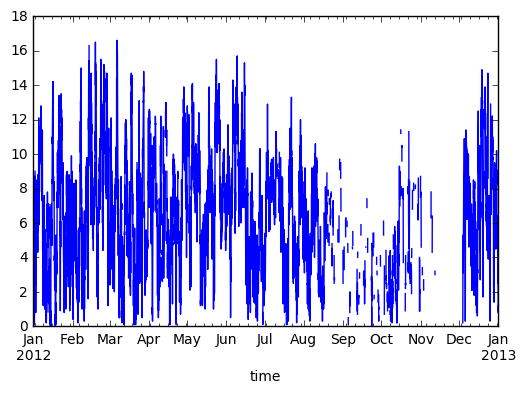

In [50]:
ndbcURL1 = 'http://coastwatch.pfeg.noaa.gov/erddap/tabledap/cwwcNDBCMet.csv?time,wspd&station="46012"&time>=2012-01-01&time<=2013-01-01'
junk = pd.read_csv(ndbcURL1, parse_dates=True, index_col='time', skiprows=[1])
junk['wspd'].plot()
plt.show()

###  IOOS Glider Data

The mission of the IOOS Glider DAC is to provide glider operators with a simple process for submitting glider data sets to a centralized location, enabling the data to be visualized, analyzed, widely distributed via existing web services and the Global Telecommunications System (GTS) and archived at the National Centers for Environmental Information (NCEI).
The IOOS Glider Dac is accessible through http://data.ioos.us/gliders/erddap/.  Extracting and plotting salinity from part of the path of one glider deployed by the Scripps Institution of Oceanography:


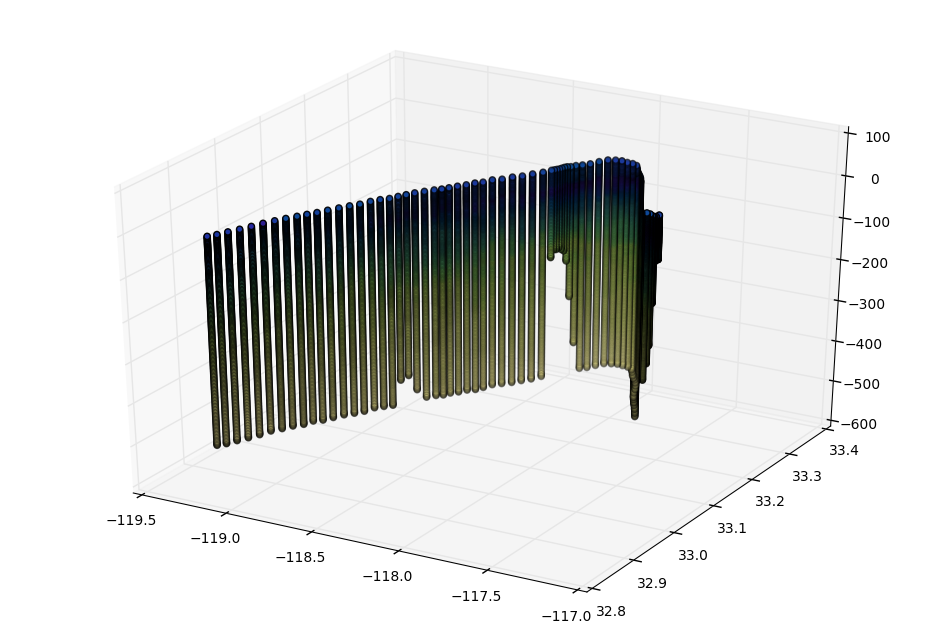

In [36]:
from mpl_toolkits.mplot3d import Axes3D
gliderURL = 'https://data.ioos.us/gliders/erddap/tabledap/sp064-20161214T1913.csv?time,latitude,longitude,depth,salinity&time>=2016-12-14&time<=2016-12-23'
junk = pd.read_csv(gliderURL, parse_dates=True, index_col='time', skiprows=[1])
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(junk['longitude'],junk['latitude'], -junk['depth'], c=junk['salinity'],  marker='o', cmap = cmocean.cm.haline)
plt.show()
